In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn import metrics

In [2]:
IMGSIZE = (128, 128)
CSIZE = 64  # channel size
train_path = 'train'
test_path = 'test'

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
if torch.cuda.is_available():
    print('GPU Model: {}'.format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU Model: NVIDIA GeForce GTX 1060


In [4]:
class ImageDataset(Dataset):
    def __init__(self, path):
        self.image_name_list = []
        self.label_list = []
        for (root, dirs, files) in os.walk(path, topdown=True):
            for names in files:
                img_name = os.path.join(root, names)
                self.image_name_list.append(img_name)
                if names[:2] == 'as':
                    self.label_list.append(0)
                else:
                    self.label_list.append(1)
    
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, idx):
        img_name = str(self.image_name_list[idx])
        img = Image.open(img_name).convert('RGB')
        img = transforms.Resize(IMGSIZE)(img)
        img = TF.to_tensor(img)
        
        label = self.label_list[idx]
        return img, label
    
    def __str__(self):
        return str(self.image_name_list)
    
    def get_label_list(self):
        return self.label_list
    
    def get_image_name_list(self):
        return self.image_name_list

In [5]:
train_data = ImageDataset(train_path)
print(f"Training data size: {len(train_data)}")

Training data size: 840


In [6]:
def _init_conv_layer(conv, activation, mode='fan_out'):
    if isinstance(activation, nn.LeakyReLU):
        torch.nn.init.kaiming_uniform_(conv.weight, 
                                       a=activation.negative_slope,
                                       nonlinearity='leaky_relu', 
                                       mode=mode)
    elif isinstance(activation, (nn.ReLU, nn.ELU)):
        torch.nn.init.kaiming_uniform_(conv.weight,
                                       nonlinearity='relu', 
                                       mode=mode)
    else:
        pass
    if conv.bias != None:
        torch.nn.init.zeros_(conv.bias)

In [7]:
class Resblock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=3, stride=1, padding=1, activation=nn.LeakyReLU()):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, k_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, k_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if self.in_channels != self.out_channels:
            self.conv = nn.Conv2d(self.in_channels, self.out_channels, 1)
            _init_conv_layer(self.conv, self.activation)
        
        _init_conv_layer(self.conv1, self.activation)
        _init_conv_layer(self.conv2, self.activation)
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.in_channels != self.out_channels:
            residual = self.conv(residual)
        x += residual
        x = self.activation(x)
        return x

In [8]:
class Convblock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=3, stride=1, padding=1, activation=nn.LeakyReLU()):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, k_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation
        
        _init_conv_layer(self.conv, self.activation)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Resnet(nn.Module):
    def __init__(self, channels, in_channels=3, num_class=2):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv_layer = Convblock(in_channels, channels//2)
        self.resblock1 = Resblock(channels//2, channels//2)
        self.resblock2 = Resblock(channels//2, channels//2)
        self.resblock3 = Resblock(channels//2, channels)
        self.resblock4 = Resblock(channels, channels)
        self.resblock5 = Resblock(channels, channels*2)
        self.resblock6 = Resblock(channels*2, channels*2)
        self.resblock7 = Resblock(channels*2, channels*4)
        self.resblock8 = Resblock(channels*4, channels*4)
        self.adapool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten() 
        self.linear = nn.Linear(channels*4, 1)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.maxpool(x)   # size = (64, 64)
        
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.maxpool(x)   # size = (32, 32)
        
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.maxpool(x)   # size = (16, 16)
        
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.maxpool(x)   # size = (8, 8)
        
        x = self.resblock7(x)
        x = self.resblock8(x)
        
        x = self.adapool(x)   # 256 x 1 x 1
        x = self.flatten(x) 
        x = self.linear(x)
        
        return x

In [10]:
# Initialize the model
resnet = Resnet(channels=CSIZE)
resnet = resnet.to(device)

In [11]:
# Print number of parameters in the model
model_parameters = filter(lambda p: p.requires_grad, resnet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

2796801


In [12]:
# Prepare trainig data, optimizer and loss function
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True, pin_memory=True)
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

In [13]:
def train(model, epoch, optimizer):
    resnet.train()
    for i in range(epoch):
        for batch_idx, data in enumerate(train_loader):
            img = data[0]
            label = data[1]
            label = label.unsqueeze(1)
            
            img = img.to(device)
            label = label.to(device)
            
            pred = model(img)
            loss = criterion(pred, label.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch {i+1}, Batch {batch_idx+1}, Loss: {loss}")
    print("Finished training")

In [14]:
train(model=resnet, epoch=30, optimizer=optimizer)

Epoch 1, Batch 1, Loss: 0.7367566823959351
Epoch 1, Batch 2, Loss: 0.7460613250732422
Epoch 1, Batch 3, Loss: 0.7710763812065125
Epoch 1, Batch 4, Loss: 0.6713249683380127
Epoch 1, Batch 5, Loss: 0.6784608364105225
Epoch 1, Batch 6, Loss: 0.6677800416946411
Epoch 1, Batch 7, Loss: 0.7165850400924683
Epoch 1, Batch 8, Loss: 0.6877836585044861
Epoch 1, Batch 9, Loss: 0.6970653533935547
Epoch 1, Batch 10, Loss: 0.7014040946960449
Epoch 1, Batch 11, Loss: 0.6718133687973022
Epoch 1, Batch 12, Loss: 0.6906275749206543
Epoch 1, Batch 13, Loss: 0.7025914788246155
Epoch 2, Batch 1, Loss: 0.6931867599487305
Epoch 2, Batch 2, Loss: 0.578265905380249
Epoch 2, Batch 3, Loss: 0.6194291710853577
Epoch 2, Batch 4, Loss: 0.637890636920929
Epoch 2, Batch 5, Loss: 0.6919388175010681
Epoch 2, Batch 6, Loss: 0.668404221534729
Epoch 2, Batch 7, Loss: 0.6677806377410889
Epoch 2, Batch 8, Loss: 0.6576529145240784
Epoch 2, Batch 9, Loss: 0.6519913673400879
Epoch 2, Batch 10, Loss: 0.6311959028244019
Epoch 2, 

Epoch 15, Batch 6, Loss: 0.1522979736328125
Epoch 15, Batch 7, Loss: 0.1936066448688507
Epoch 15, Batch 8, Loss: 0.11225610971450806
Epoch 15, Batch 9, Loss: 0.18638665974140167
Epoch 15, Batch 10, Loss: 0.16515979170799255
Epoch 15, Batch 11, Loss: 0.17123885452747345
Epoch 15, Batch 12, Loss: 0.18873241543769836
Epoch 15, Batch 13, Loss: 0.22204682230949402
Epoch 16, Batch 1, Loss: 0.1552322506904602
Epoch 16, Batch 2, Loss: 0.12986232340335846
Epoch 16, Batch 3, Loss: 0.2507876753807068
Epoch 16, Batch 4, Loss: 0.10958702862262726
Epoch 16, Batch 5, Loss: 0.10480420291423798
Epoch 16, Batch 6, Loss: 0.1031384989619255
Epoch 16, Batch 7, Loss: 0.17952904105186462
Epoch 16, Batch 8, Loss: 0.1713240146636963
Epoch 16, Batch 9, Loss: 0.2350499927997589
Epoch 16, Batch 10, Loss: 0.09089444577693939
Epoch 16, Batch 11, Loss: 0.2690686583518982
Epoch 16, Batch 12, Loss: 0.157575786113739
Epoch 16, Batch 13, Loss: 0.2001921534538269
Epoch 17, Batch 1, Loss: 0.12718267738819122
Epoch 17, Bat

Epoch 29, Batch 6, Loss: 0.09646086394786835
Epoch 29, Batch 7, Loss: 0.08886697888374329
Epoch 29, Batch 8, Loss: 0.17932626605033875
Epoch 29, Batch 9, Loss: 0.11290422081947327
Epoch 29, Batch 10, Loss: 0.04426845908164978
Epoch 29, Batch 11, Loss: 0.06737367808818817
Epoch 29, Batch 12, Loss: 0.11213946342468262
Epoch 29, Batch 13, Loss: 0.16664724051952362
Epoch 30, Batch 1, Loss: 0.06048097461462021
Epoch 30, Batch 2, Loss: 0.07015751302242279
Epoch 30, Batch 3, Loss: 0.10599521547555923
Epoch 30, Batch 4, Loss: 0.18164095282554626
Epoch 30, Batch 5, Loss: 0.0610169917345047
Epoch 30, Batch 6, Loss: 0.07322242856025696
Epoch 30, Batch 7, Loss: 0.04322653263807297
Epoch 30, Batch 8, Loss: 0.08620115369558334
Epoch 30, Batch 9, Loss: 0.1755165308713913
Epoch 30, Batch 10, Loss: 0.12804582715034485
Epoch 30, Batch 11, Loss: 0.10941536724567413
Epoch 30, Batch 12, Loss: 0.09609169512987137
Epoch 30, Batch 13, Loss: 0.1247216984629631
Finished training


In [15]:
def validate(model, loader):
    model.eval()
    result = []
    correct = 0
    with torch.no_grad():
        for data in loader:
            img = data[0]
            label = data[1]
            label = label.unsqueeze(1)
            
            img = img.to(device)
            label = label.to(device)
            
            pred = model(img)
            if pred > 0.5:
                pred = 1
            else:
                pred = 0
            
            result.append(pred)
            
    return result

In [16]:
train_data = ImageDataset(train_path)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False, drop_last=False)

In [17]:
result = validate(resnet, train_loader)

In [18]:
# Plot the confusion matrix to better understand the model
def plot_confusion_matrix(result):
    plt.figure(figsize=(5, 5))
    cm = metrics.confusion_matrix(train_data.get_label_list(), result)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

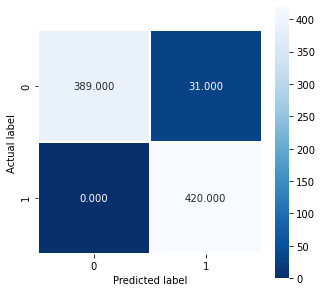

In [19]:
plot_confusion_matrix(result)

In [20]:
# Calculate the area under the receiver operating characteristic
auroc = metrics.roc_auc_score(train_data.get_label_list(), result)
print(f"AUROC: {auroc}")

AUROC: 0.9630952380952381


In [21]:
# Save the model's weight
torch.save({'model_state_dict': resnet.state_dict()}, 'elephant.h5')

In [22]:
# Retrieve the model from previously saved weight for inference
model = Resnet(64)
weight = torch.load('elephant.h5')
model.load_state_dict(weight['model_state_dict'])

<All keys matched successfully>

In [23]:
test_data = ImageDataset(test_path)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=False)

In [24]:
# Classify test data and write the prediction into a csv file
result = validate(resnet, test_loader)
fields = ['ID', 'result']
rows = list(zip([x[5:9] for x in test_data.get_image_name_list()], result))
filename = 'elephant.csv'
with open(filename, 'w' , newline='') as csvfile: 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)